In [1]:
import torch
import torch.nn as nn
import numpy as np
import normflows as nf
import numpy as np

import Train

from matplotlib import pyplot as plt
from tqdm import tqdm
from Base import DirichletProcessMixture
from HeavyTarget import AsymmetricStudentT, MixtureTarget, MultStudentT


In [2]:
#set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [3]:
# set seed.
torch.manual_seed(0)
np.random.seed(0)


dimension = 1
#base = DPGM(shape=dimension, T=10)
base = DirichletProcessMixture(shape=dimension, T=2)
#base = DirichletProcessGaussianMixture(shape=dimension, T=10)
#base = DirichletProcessPoductTMixture(shape = dimension, T=1, df=[[2,4], [10,10]])
#base = DirichletProcessPoductTMixture(shape = dimension, T=1, df=2)

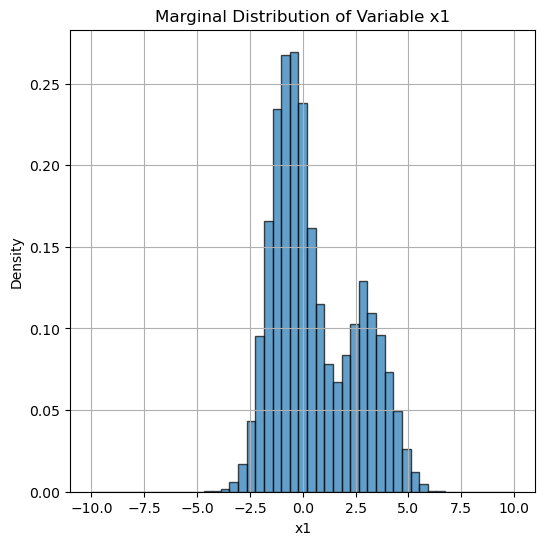

In [4]:
Train.plot_samples(base, two_d=True, min=-10, max=10)

In [5]:
Train.print_model_parameters(base)

--- stick-breaking params ---
  a: [1.0000]
  b: [1.0000]
  pi (expected): [0.5000, 0.5000]

--- component #0 (GaussianDistribution) ---
  mean: [3.0820]
  scale: [1.0000]

--- component #1 (GaussianDistribution) ---
  mean: [-0.5869]
  scale: [1.0000]



In [6]:
'''
target1 = AsymmetricStudentT(df=(30,30), mean=(0,5))
target2 = AsymmetricStudentT(df=(30,30), mean=(2,-4))
target3 = nf.distributions.DiagGaussian(shape=2)
target = MixtureTarget(target1, target2, weight=(0.5, 0.5))
target = MixtureTarget(target, target3, weight=(0.5, 0.5))
'''
'''
target = AsymmetricStudentT(df=3)
'''
target1 = MultStudentT(df = 30, mean=[3.0820])
target2 = MultStudentT(df = 30, mean=[-0.5869])
target = MixtureTarget(target1, target2, weight=(0.7, 0.3))



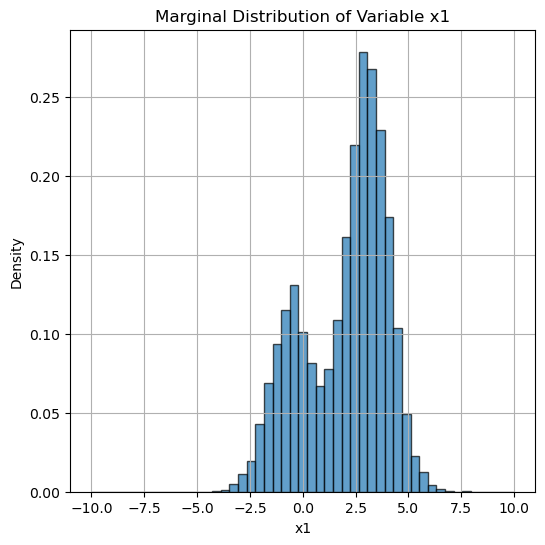

In [7]:
Train.plot_samples(target, two_d=True, min=-10, max=10)

In [8]:
K = 2
latent_size = dimension
hidden_units = 64
hidden_layers = 3

flows = []

for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    #flows += [nf.flows.LULinearPermute(latent_size, identity_init=True)]

model = nf.NormalizingFlow(base, flows, p=target)
model = model.to(torch.float32)

  0%|          | 0/1200 [00:00<?, ?it/s]

Iteration 0, loss: 0.8184744119644165


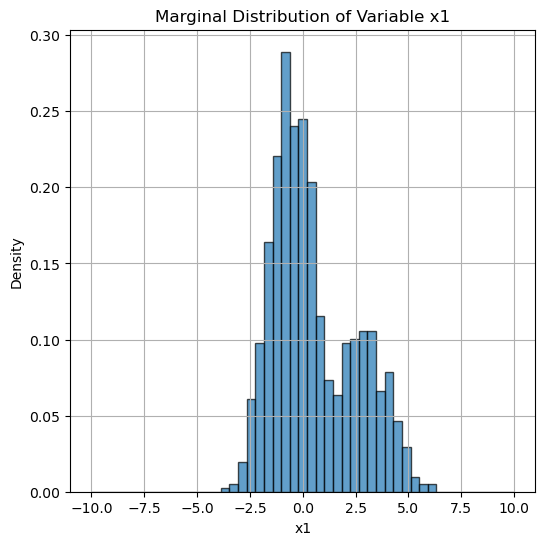

 23%|██▎       | 276/1200 [00:01<00:02, 336.78it/s]

Iteration 300, loss: 0.24233317375183105


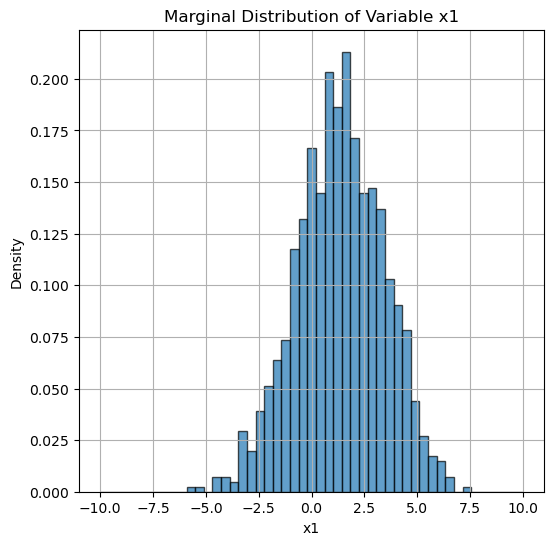

 48%|████▊     | 579/1200 [00:02<00:01, 338.84it/s]

Iteration 600, loss: 0.1544933319091797


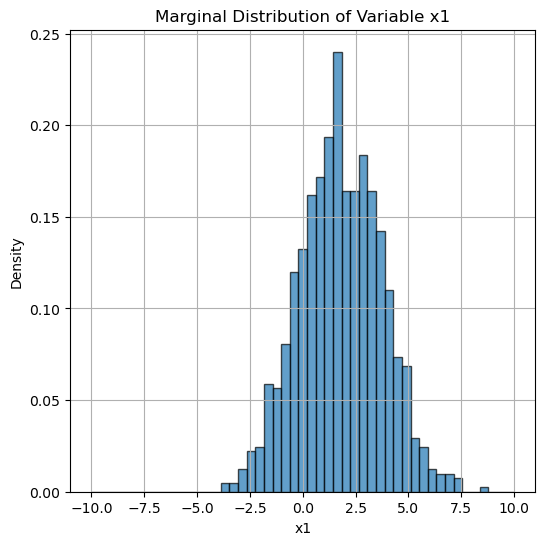

 74%|███████▎  | 882/1200 [00:03<00:01, 196.27it/s]

Iteration 900, loss: 0.02647113800048828


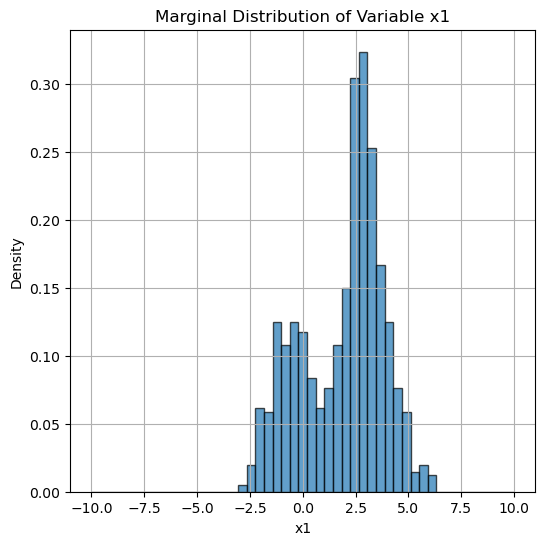

100%|██████████| 1200/1200 [00:05<00:00, 222.51it/s]


In [9]:
max_iter = 1200
lr = 5e-3
num_samples = 2**10
show_iter = 300
weight_decay = 1e-5
freeze_flow = True # freeze flow parameters
freeze_ratio = 0.5 # do not update flow parameters. 

loss_hist = np.array([])

# Freeze the flow parameters
for param in model.flows.parameters():
    param.requires_grad = False
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    loss = model.reverse_kld(num_samples)
    if it == int(max_iter * freeze_ratio):
        if freeze_flow:
            for param in model.flows.parameters():
                param.requires_grad = True
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward(retain_graph=True)
        optimizer.step()
        if it % show_iter == 0:
            print(f"Iteration {it}, loss: {loss.item()}")
            Train.plot_samples(model, num_samples=1000, two_d=True, min=-10, max=10)
        
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

 12%|█▏        | 492/4000 [00:01<00:11, 299.03it/s]/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Iteration 500, eta: 0.9777


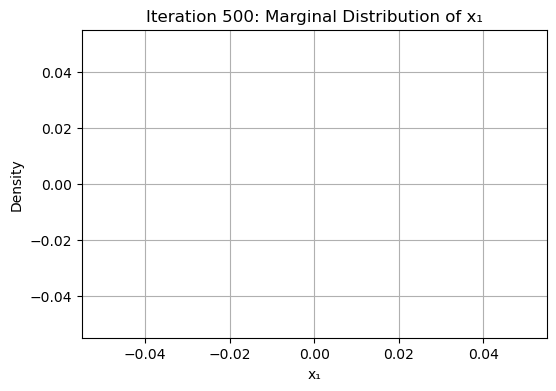

 13%|█▎        | 524/4000 [00:01<00:14, 239.42it/s]

0.5735502


 25%|██▍       | 997/4000 [00:03<00:09, 327.28it/s]

Iteration 1000, eta: 1.0440


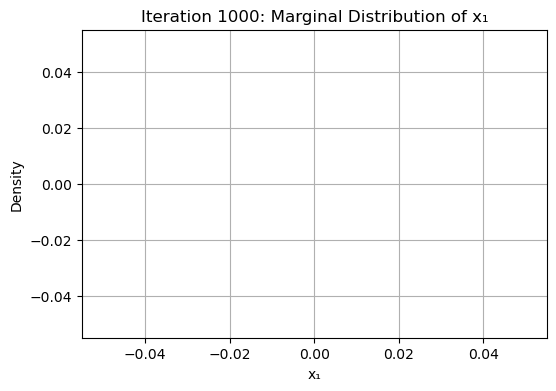

 26%|██▌       | 1030/4000 [00:03<00:11, 257.21it/s]

0.19109094


 30%|██▉       | 1192/4000 [00:03<00:10, 280.53it/s]/var/folders/5w/tg5gxnpx7tdgm7xwhh9_zt4c0000gn/T/ipykernel_39310/3145146403.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nu_hats_all.append(torch.tensor(nu_hat_vec, device=means.device, dtype=new_base.df.dtype))
 31%|███▏      | 1254/4000 [00:04<00:09, 289.56it/s]

[tensor([2.9233]), tensor([2.9684]), tensor([2.5730]), tensor([2.9385]), tensor([2.8844]), tensor([2.7769]), tensor([2.9142]), tensor([2.7885]), tensor([2.8559]), tensor([2.9779])]


 37%|███▋      | 1487/4000 [00:04<00:07, 329.12it/s]

Iteration 1500, eta: 1.0489


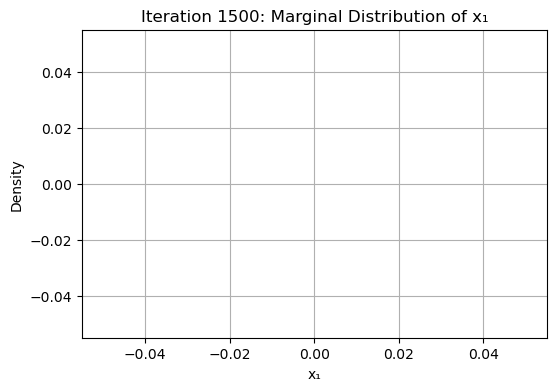

 38%|███▊      | 1520/4000 [00:05<00:09, 256.62it/s]

-0.0012501478


 49%|████▉     | 1976/4000 [00:06<00:05, 340.13it/s]

Iteration 2000, eta: 1.0489


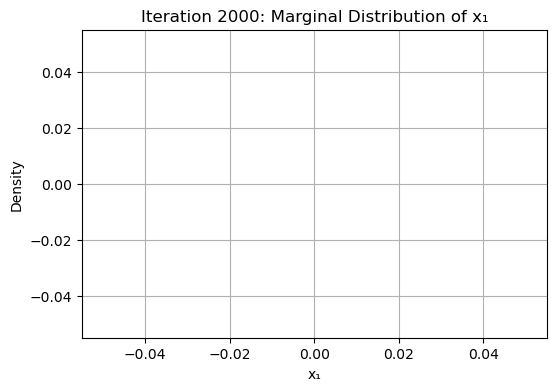

 50%|█████     | 2011/4000 [00:06<00:07, 254.12it/s]

-0.0005699396


 62%|██████▏   | 2490/4000 [00:09<00:07, 206.40it/s]

Iteration 2500, eta: 1.0489


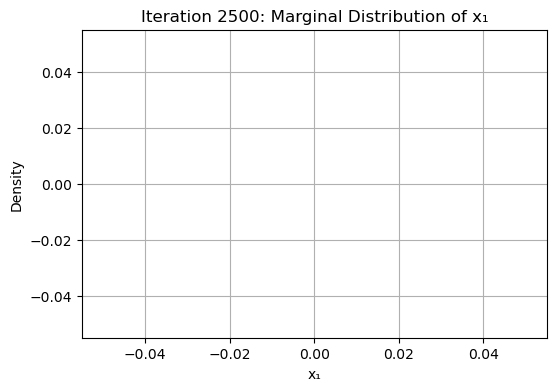

 63%|██████▎   | 2511/4000 [00:09<00:08, 166.10it/s]

0.005638838


 75%|███████▍  | 2989/4000 [00:11<00:05, 176.79it/s]

Iteration 3000, eta: 1.0489


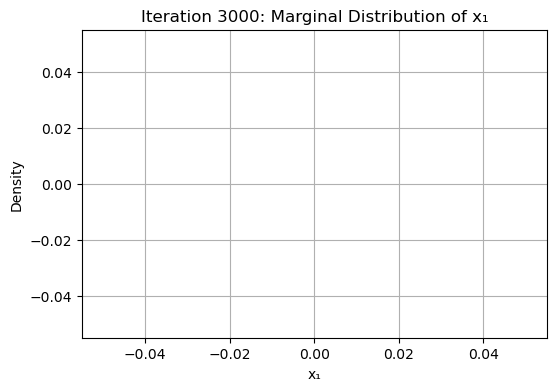

 75%|███████▌  | 3008/4000 [00:12<00:07, 135.71it/s]

0.0011765957


 87%|████████▋ | 3489/4000 [00:14<00:02, 185.20it/s]

Iteration 3500, eta: 1.0489


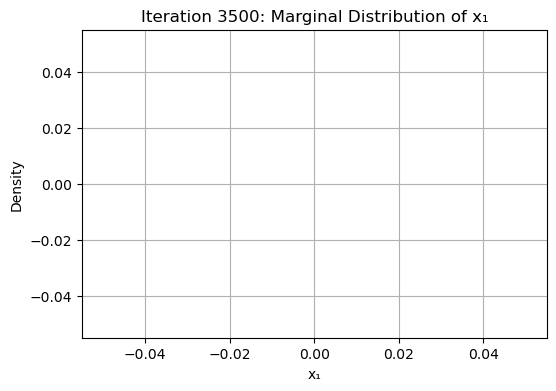

 88%|████████▊ | 3508/4000 [00:15<00:03, 143.19it/s]

0.0036798716


100%|█████████▉| 3991/4000 [00:17<00:00, 201.47it/s]

Iteration 4000, eta: 1.0489


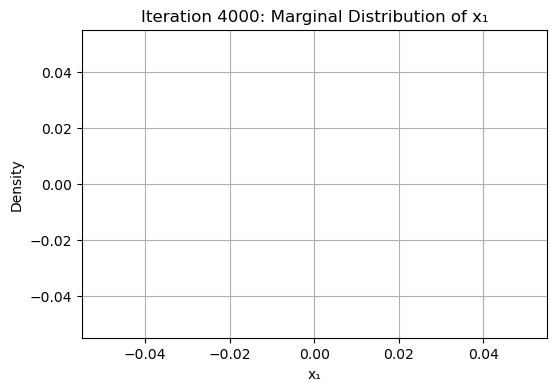

100%|██████████| 4000/4000 [00:17<00:00, 223.59it/s]

0.00092589855


In [208]:
# Training parameters
max_iter = 4000
lr = 5e-3
weight_decay = 1e-5
freeze_ratio = 0.5 # do not update flow parameters. 
update_beta_ratio = 0.3
freeze_flow = True
num_samples = 2**10
show_iter = 500
loss_hist = np.array([])

# Freeze the flow parameters
for param in model.flows.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    loss = model.reverse_kld(num_samples)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward(retain_graph=True)
        optimizer.step()
        if it < max_iter * update_beta_ratio:
            model.q0.update_beta()
    if it == int(max_iter * freeze_ratio):
        if freeze_flow:
            for param in model.flows.parameters():
                param.requires_grad = True
    if it == int(max_iter * update_beta_ratio):
        model.q0.log_eta.requires_grad = False
        #### tail index estimation and update base distribution ####
        
        model.eval()
        new_base = DirichletProcessPoductTMixture(shape=dimension, T=model.q0.T, train_eta=False)
        new_base.log_eta.data = model.q0.log_eta.data.clone() 
        new_base.means.data = model.q0.means.data.clone()  
        new_base.log_scale.data = model.q0.log_scale.data.clone()
        model.q0 = new_base

        with torch.no_grad():
            weights = torch.softmax(model.q0.log_pi, dim=0)           # (T,)
            means   = model.q0.means.clone()                          # (T, d)
            scales  = model.q0.log_scale.exp().clone()               # (T, d)
            T, d    = means.shape

        # --- 2) For each component t and each dimension, estimate tail index nu_hat ---
        dfs = []
        nu_hats_all = []
        global_mean = Train.compute_global_mean(model.q0)
        for t in range(T):
            # returns ndarray or list of length d
            nu_hat_vec = Train.estimate_tail_indices_t(
                mean=means[t].detach().cpu().numpy(),
                scale=scales.detach().cpu().numpy(),
                df=2.0,
                global_mean=global_mean,
                target=model.p,
                num_samples=3000,
                k=2990
            )
            # to torch.Tensor on right device & dtype
            nu_hats_all.append(torch.tensor(nu_hat_vec, device=means.device, dtype=new_base.df.dtype))
        print(nu_hats_all)
        # stack into (T, d)
        nu_hats_tensor = torch.stack(nu_hats_all)  # shape: (T, d)

        # clamp out-of-bounds to 30
        df_new = torch.where(
            (nu_hats_tensor >= 1.0) & (nu_hats_tensor <= 30.0),
            nu_hats_tensor,
            torch.full_like(nu_hats_tensor, 30.0)
        )  # (T, d)

        # reshape into (T, *shape) matching new_base.df
        df_buffer = df_new.view_as(new_base.df)

        # copy into the df buffer
        new_base.df.copy_(df_buffer)

        model.train() # back to training mode
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        if dimension==2:
            grid_size = 200
            xx, yy = torch.meshgrid(torch.linspace(-20, 20, grid_size), torch.linspace(-20, 20, grid_size))
            zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
            
            model.eval()
            log_prob = model.log_prob(zz)
            prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
            prob[torch.isnan(prob)] = 0

            # 현재 eta 값 계산 (scalar)
            eta_value = torch.exp(model.q0.log_eta).item()
            print(f"Iteration {it+1}, eta: {eta_value:.4f}")
            model.train()

            plt.figure(figsize=(5, 5))
            plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
            plt.gca().set_aspect('equal', 'box')
            plt.show()
        else:
            model.eval()  # 평가 모드 전환

            eta_value = torch.exp(model.q0.log_eta).item()
            print(f"Iteration {it+1}, eta: {eta_value:.4f}")
            # 샘플링
            samples, _ = model.sample(num_samples=1000)
            x1 = samples[:, 0].detach().cpu().numpy()

            # 히스토그램 그리기
            bins = np.arange(38, 100, 1)
            plt.figure(figsize=(6, 4))
            plt.hist(x1, bins=bins, density=True, alpha=0.7, edgecolor='black')
            plt.title(f'Iteration {it+1}: Marginal Distribution of x₁')
            plt.xlabel('x₁')
            plt.ylabel('Density')
            plt.grid(True)
            plt.show()
            print(loss.to('cpu').data.numpy())
            model.train()  # 다시 학습 모드로 전환


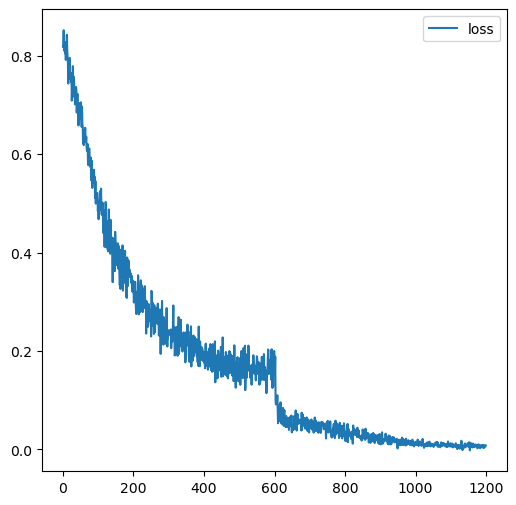

In [10]:
plt.figure(figsize=(6, 6))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

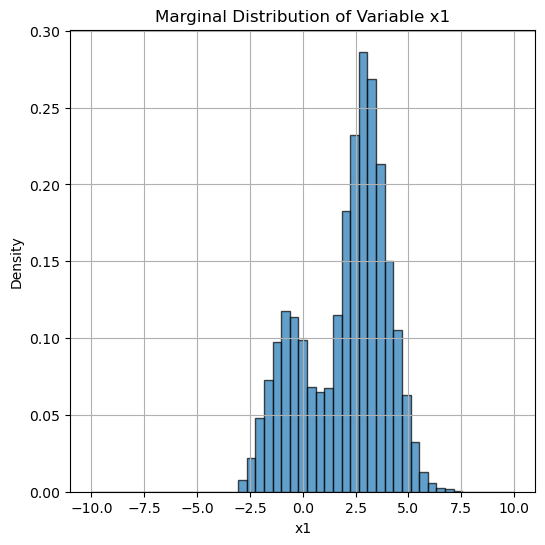

In [11]:
Train.plot_samples(model, min=-10, max=10)

In [12]:
Train.print_model_parameters(model.q0)

--- stick-breaking params ---
  a: [1.0000]
  b: [1.0000]
  pi (expected): [0.5000, 0.5000]

--- component #0 (GaussianDistribution) ---
  mean: [2.5737]
  scale: [1.2563]

--- component #1 (GaussianDistribution) ---
  mean: [2.5626]
  scale: [1.2524]



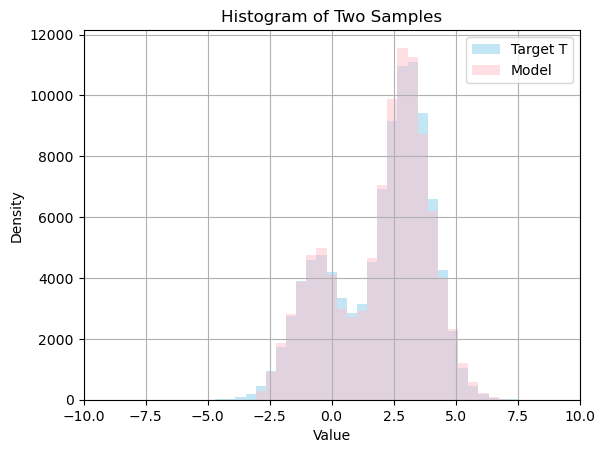

In [13]:
marginal = 1
s1 = target.sample(num_samples=100000).cpu().detach().numpy()[:, marginal-1]
s2 = model.q0.forward(100000)[0].cpu().detach().numpy()[:, marginal-1]
s3 = model.sample(100000)[0].detach().numpy()[:, marginal-1]

min = -10
max = 10
bins = 50

# 히스토그램 그리기
plt.hist(s1, bins=np.linspace(min, max, bins), alpha=0.5, label='Target T', color='skyblue', density=False)
#plt.hist(s2, bins=np.linspace(min, max, bins), alpha=0.5, label='Base Mixture', color='orange', density=False)
plt.hist(s3, bins=np.linspace(min, max, bins), alpha=0.5, label='Model', color='pink', density=False)

# 라벨 및 범례
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Two Samples')
plt.legend()
plt.xlim(min,max)
plt.grid(True)
plt.show()

In [29]:
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

# Grid 설정
grid_size = 200
x = torch.linspace(-10, 10, grid_size)
y = torch.linspace(-10, 10, grid_size)
xx, yy = torch.meshgrid(x, y, indexing='xy')

# 위치 벡터 생성
pos = torch.stack([xx, yy], dim=-1)  # shape: (grid_size, grid_size, 2)

# 2D 정규분포 정의
dist = MultivariateNormal(torch.zeros(2), torch.eye(2))

# log_prob 계산 후 확률로 변환
zz = pos.view(-1, 2)
log_prob = base.log_prob(zz).view(grid_size, grid_size)
prob = torch.exp(log_prob)

# 등고선 그리기
plt.figure(figsize=(5, 5))
CS = plt.contour(xx.detach().numpy(), yy.detach().numpy(), prob.detach().numpy())
#plt.clabel(CS, inline=1, fontsize=10)
plt.gca().set_aspect('equal', 'box')
plt.title('2D Gaussian Contour')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


RuntimeError: shape '[40000, 1]' is invalid for input of size 80000